------------------
 ## Suicide Sentiment Analysis Project 
 - Using TF-IDF As Feature Extraction
 - Using Some Classification models As RandomForest, LinearSVC, MultinomialNB
 - Using Some Preprocessing as Lemmatization, Removing Stop Words
 - Finally,  The best Results in this notebook is 91%.
----------------

In [1]:
import pandas as pd
import numpy as np 
from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import metrics
nltk.download('vader_lexicon')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nouran\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Read Suicide_Detection File

In [2]:
Suicide = pd.read_csv('Suicide_Detection.csv')
data_split = np.array_split(Suicide, 20)
Suicide = data_split[0]
Suicide = Suicide.drop('Unnamed: 0',axis=1)

## Preparing For Stopword removal and lemmatization

In [3]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nouran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
X = Suicide.drop('class', axis=1)
y = Suicide['class']

# Text Pre Proceessing

In [5]:
# To remove emails
email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
regexes_to_remove = [email_regex, r'Subject:', r'Re:']

for i in range(0, len(X)):
    # removing all special charachter
    review = re.sub('[^a-zA-Z]', ' ', str(X['text'][i]))
    # make document as lowerCase
    review = review.lower()
    # splitting the documents into words for ex ['iam', 'omar']
    review = review.split()
    # make limmatization --> (change, changing, changes)---> (change)
    review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords)]
    # join the document agian
    review = ' '.join(review)
    
    # removing mails
    for r in regexes_to_remove:
        X['text'][i] = re.sub(r, '', review)


## Data Splitting 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Feature extraction

- ### TF-IDF

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer_n12 = TfidfVectorizer(max_features=10000, ngram_range=(1,2))


X_tfidf_train = tfidf_vectorizer.fit_transform(X_train['text'])
X_tfidf_test = tfidf_vectorizer.transform(X_test['text'])

X_tfidf_train_n12= tfidf_vectorizer_n12.fit_transform(X_train['text'])
X_tfidf_test_n12=tfidf_vectorizer_n12.transform(X_test['text'])

 - ### Bag of wards 

In [8]:
vectorizer = CountVectorizer()
  
X_bow_train = vectorizer.fit_transform(X_train['text'])
X_bow_test = vectorizer.transform(X_test['text'])


- ### VADER


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
def get_vedor_scores(data):
    sid=SIA()
    vedor_df=data.copy()
    vedor_df['scores'] = vedor_df['text'].apply(lambda txt: sid.polarity_scores(str(txt)))
    
    vedor_df['neg_score'] = vedor_df['scores'].apply(lambda txt: txt['neg'])
    vedor_df['neu_score'] =vedor_df['scores'].apply(lambda txt: txt['neu'])
    vedor_df['pos_score'] = vedor_df['scores'].apply(lambda txt: txt['pos'])
    vedor_df['compound'] = vedor_df['scores'].apply(lambda txt: txt['compound'])
    vedor_df.drop('scores', axis=1, inplace=True)
    vedor_df.drop('text', axis=1, inplace=True)
    return vedor_df


In [10]:
X_vedor_train = get_vedor_scores(X_train)
X_vedor_test= get_vedor_scores(X_test)

In [11]:
X_vedor_train

,neg_score,neu_score,pos_score,compound
8282,0.210,0.563,0.227,-0.2984
9389,0.252,0.667,0.081,-0.6808
2886,0.304,0.696,0.000,-0.5423
5254,0.417,0.355,0.228,-0.9653
6583,0.214,0.549,0.237,0.9528
...,...,...,...,...
8059,0.239,0.573,0.189,-0.9948
2481,0.304,0.576,0.120,-0.9937
7422,0.168,0.508,0.324,0.9753
2177,0.292,0.519,0.188,-0.3818


In [12]:
X_vedor_test

,neg_score,neu_score,pos_score,compound
5063,0.000,0.556,0.444,0.7906
9636,0.251,0.439,0.310,0.5945
3776,0.000,0.826,0.174,0.2263
3273,0.334,0.564,0.102,-0.9591
1792,0.139,0.861,0.000,-0.3774
...,...,...,...,...
2760,0.306,0.552,0.143,-0.9884
9249,0.000,1.000,0.000,0.0000
10888,0.000,1.000,0.000,0.0000
8407,0.192,0.550,0.259,0.3612


## Feature Selection

In [13]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# We Can select any model but linearSVC has l1 norm penality which deals with sparse
lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_tfidf_train, y_train)

# This function select the best features that has high weigh
fs = SelectFromModel(lsvc, prefit=True)
# This function redeuce X to the selected features
X_selection = fs.transform(X_tfidf_train)
X_test_selection = fs.transform(X_tfidf_test)


lsvc.fit(X_tfidf_train_n12, y_train)
fs_n12 = SelectFromModel(lsvc, prefit=True)
X_selection_n12 = fs_n12.transform(X_tfidf_train_n12)
X_test_selection_n12 = fs_n12.transform(X_tfidf_test_n12)

lsvc.fit(X_bow_train, y_train)
fs_n12 = SelectFromModel(lsvc, prefit=True)
X_selection_bow = fs_n12.transform(X_bow_train)
X_test_selection_bow = fs_n12.transform(X_bow_test)


### plotting results function 

In [14]:
import matplotlib.pyplot as plt
def plot_results(data):
    
    barWidth = 0.15
    # set heights of bars

    bars1 = [data[0][1],data[1][1], data[2][1]]
    bars2 = [data[0][2], data[1][2], data[2][2]]
    bars3 = [data[0][3], data[1][3], data[2][3]]
    bars4 = [data[0][4], data[1][4], data[2][4]]
    

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    

    # Make the plot
    plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='tfidf')
    plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='tfidf_n12')
    plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='bow')
    plt.bar(r4, bars4, color='#9a7f5e', width=barWidth, edgecolor='white', label='vedor')
    

    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], ['precision', 'recall', 'f1-score'])

    # Create legend & Show graphic
    plt.legend()
    plt.grid()
    plt.show()

##  Using LinearSVC

In [15]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_selection, y_train)
y_predict_tfidf = lsvc.predict(X_test_selection)

lsvc.fit(X_selection_n12,y_train)
y_predict_tfidf_n12 = lsvc.predict(X_test_selection_n12)

lsvc.fit(X_selection_bow,y_train)
y_predict_bow = lsvc.predict(X_test_selection_bow)

lsvc.fit(X_vedor_train,y_train)
y_predict_vedor = lsvc.predict(X_vedor_test)

linear_svm_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf)
linear_svm_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12)
linear_svm_bow_results=metrics.precision_recall_fscore_support(y_test, y_predict_bow)
vedor_svm_results=metrics.precision_recall_fscore_support(y_test, y_predict_vedor)

In [16]:
data1 = [['TF-IDF','TF-IDF 2-grams ','bag of words','vedor'],
         ['precision',linear_svm_tfidf_results[0][0],linear_svm_tfidf_n12_results[0][0],linear_svm_bow_results[0][0],
          vedor_svm_results[0][0]],
         ['recall',linear_svm_tfidf_results[1][0],linear_svm_tfidf_n12_results[1][0],linear_svm_bow_results[1][0],
          vedor_svm_results[1][0]],
         ['F1-score',linear_svm_tfidf_results[2][0],linear_svm_tfidf_n12_results[2][0],linear_svm_bow_results[2][0],
          vedor_svm_results[2][0]]]

In [17]:
print(tabulate(data1,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════╤══════════╤═══════════════════╤════════════════╤══════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   bag of words │    vedor │
╞═══════════╪══════════╪═══════════════════╪════════════════╪══════════╡
│ precision │ 0.868113 │          0.887986 │       0.864726 │ 0.694584 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ recall    │ 0.843875 │          0.871795 │       0.863248 │ 0.708832 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ F1-score  │ 0.855822 │          0.879816 │       0.863986 │ 0.701636 │
╘═══════════╧══════════╧═══════════════════╧════════════════╧══════════╛


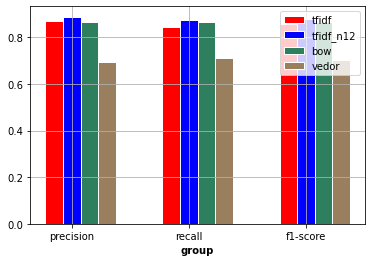

In [18]:
plot_results(data1[1:])

## Using RandomForest

In [19]:
clf = RandomForestClassifier(max_depth=10)
clf.fit(X_selection, y_train)
y_predict_tfidf_2 = clf.predict(X_test_selection)

clf.fit(X_selection_n12, y_train)
y_predict_tfidf_n12_2 = clf.predict(X_test_selection_n12)

clf.fit(X_selection_bow, y_train)
y_predict_bow_2 = clf.predict(X_test_selection_bow)

clf.fit(X_vedor_train, y_train)
y_predict_vedor_2 = clf.predict(X_vedor_test)

In [20]:
RandomForest_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_2)
RandomForest_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12_2)
RandomForest_bow_results=metrics.precision_recall_fscore_support(y_test, y_predict_bow_2)
RandomForest_vedor_results=metrics.precision_recall_fscore_support(y_test, y_predict_vedor_2)

In [21]:
data2 = [['TF-IDF','TF-IDF 2-grams ','bag of words','vedor'],
         ['precision',RandomForest_tfidf_results[0][0],RandomForest_tfidf_n12_results[0][0],RandomForest_bow_results[0][0],
          RandomForest_vedor_results[0][0]],
         ['recall',RandomForest_tfidf_results[1][0],RandomForest_tfidf_n12_results[1][0],RandomForest_bow_results[1][0],
          RandomForest_vedor_results[1][0]],
         ['F1-score',RandomForest_tfidf_results[2][0],RandomForest_tfidf_n12_results[2][0],RandomForest_bow_results[2][0],
          RandomForest_vedor_results[2][0]]]

In [22]:
print(tabulate(data2,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════╤══════════╤═══════════════════╤════════════════╤══════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   bag of words │    vedor │
╞═══════════╪══════════╪═══════════════════╪════════════════╪══════════╡
│ precision │ 0.801858 │          0.810159 │       0.801531 │ 0.786876 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ recall    │ 0.88547  │          0.899715 │       0.895157 │ 0.77208  │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ F1-score  │ 0.841592 │          0.852592 │       0.84576  │ 0.779408 │
╘═══════════╧══════════╧═══════════════════╧════════════════╧══════════╛


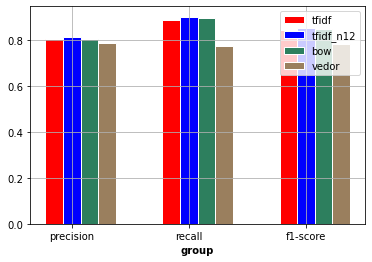

In [23]:
plot_results(data2[1:])

## Using Ensamble Learning 

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression,  SGDClassifier
from sklearn.svm import SVC

In [25]:
log_clf = LogisticRegression(solver="lbfgs")
rnd_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma="scale", probability=True)
sgd = SGDClassifier(alpha=.0001, max_iter=50, loss='log',
                                       penalty="elasticnet", n_jobs=-1)

voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf),('sgd', sgd)],
voting='soft')

In [26]:
voting_clf.fit(X_selection, y_train)
y_predict_tfidf_4 = voting_clf.predict(X_test_selection)

voting_clf.fit(X_selection_n12, y_train)
y_predict_tfidf_n12_4 = voting_clf.predict(X_test_selection_n12)

voting_clf.fit(X_selection_bow, y_train)
y_predict_bow_4 = voting_clf.predict(X_test_selection_bow)

voting_clf.fit(X_vedor_train, y_train)
y_predict_vedor_4 = voting_clf.predict(X_vedor_test)

In [27]:
mb_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_4)
mb_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12_4)
mb_bow_results=metrics.precision_recall_fscore_support(y_test, y_predict_bow_4)
mb_vedor_results=metrics.precision_recall_fscore_support(y_test, y_predict_vedor_4)

In [28]:
data3= [['TF-IDF','TF-IDF 2-grams ','bag of words','vedor'],
        ['precision',mb_tfidf_results[0][0],mb_tfidf_n12_results[0][0],mb_bow_results[0][0],
          mb_vedor_results[0][0]],
         ['recall',mb_tfidf_results[1][0],mb_tfidf_n12_results[1][0],mb_bow_results[1][0],
          mb_vedor_results[1][0]],
         ['F1-score',mb_tfidf_results[2][0],mb_tfidf_n12_results[2][0],mb_bow_results[2][0],
          mb_vedor_results[2][0]]]

In [29]:
print(tabulate(data3,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════╤══════════╤═══════════════════╤════════════════╤══════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   bag of words │    vedor │
╞═══════════╪══════════╪═══════════════════╪════════════════╪══════════╡
│ precision │ 0.897959 │          0.89745  │       0.904086 │ 0.765277 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ recall    │ 0.927635 │          0.922507 │       0.907692 │ 0.763533 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ F1-score  │ 0.912556 │          0.909806 │       0.905886 │ 0.764404 │
╘═══════════╧══════════╧═══════════════════╧════════════════╧══════════╛


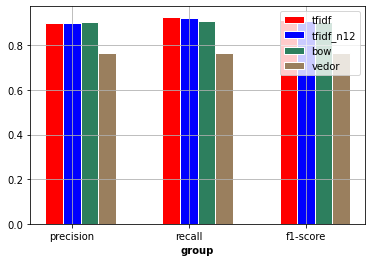

In [30]:
plot_results(data3[1:])

## Using Bagging Method

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500,
max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_selection, y_train)
y_pred_5 = bag_clf.predict(X_test_selection)

bag_clf.fit(X_selection_n12, y_train)
y_pred_n12_5 = bag_clf.predict(X_test_selection_n12)

bag_clf.fit(X_selection_bow, y_train)
y_pred_bow_5 = bag_clf.predict(X_test_selection_bow)

bag_clf.fit(X_vedor_train, y_train)
y_pred_vedor_5 = bag_clf.predict(X_vedor_test)

In [32]:
bag_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_pred_5)
bag_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_pred_n12_5)
bag_bow_results=metrics.precision_recall_fscore_support(y_test, y_pred_bow_5)
bag_vedor_results=metrics.precision_recall_fscore_support(y_test, y_pred_vedor_5)

In [33]:
data4= [['TF-IDF','TF-IDF 2-grams ','bag of words','vedor'],
        ['precision',bag_tfidf_results[0][0],bag_tfidf_n12_results[0][0],bag_bow_results[0][0],
          bag_vedor_results[0][0]],
         ['recall',bag_tfidf_results[1][0],bag_tfidf_n12_results[1][0],bag_bow_results[1][0],
          bag_vedor_results[1][0]],
         ['F1-score',bag_tfidf_results[2][0],bag_tfidf_n12_results[2][0],bag_bow_results[2][0],
          bag_vedor_results[2][0]]]

In [34]:
print(tabulate(data4,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════╤══════════╤═══════════════════╤════════════════╤══════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   bag of words │    vedor │
╞═══════════╪══════════╪═══════════════════╪════════════════╪══════════╡
│ precision │ 0.803778 │          0.802591 │       0.801482 │ 0.784714 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ recall    │ 0.872934 │          0.882621 │       0.862678 │ 0.766382 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ F1-score  │ 0.83693  │          0.840706 │       0.830955 │ 0.77544  │
╘═══════════╧══════════╧═══════════════════╧════════════════╧══════════╛


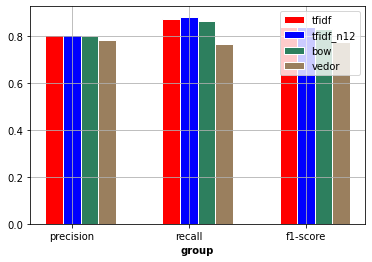

In [35]:
plot_results(data4[1:])